# 05 Model Comparison: Transformer vs. LSTM
#
# Funktion:
# Dieses Notebook vergleicht die Performance des Transformer-Modells mit dem LSTM-Modell.
# Es lädt automatisch die Ergebnisse des neuesten LSTM-Runs und stellt sie den aktuellen Transformer-Ergebnissen gegenüber.
#
# Vergleichsbasis:
# - Test-Zeitraum: 2025-01-01 bis 2025-12-31
# - Daten: Identische Features & Zeitreihen (aus dem LSTM-Datenverzeichnis)
# - Metriken: Accuracy, Balanced Accuracy, ROC AUC, MCC


In [11]:
# === IMPORTS ===
import torch
import pandas as pd
import numpy as np
import json
import pickle
import sys
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score

# Root-Verzeichnis zum Pfad hinzufügen
ROOT = Path("..").resolve()
sys.path.append(str(ROOT))
from finance_transformer.model import TimeSeriesTransformer

print("Libraries loaded.")

Libraries loaded.


In [12]:
# === 1. LSTM ERGEBNISSE LADEN ===
# Wir suchen automatisch den neuesten '_lstm' Ordner im LSTM/results Verzeichnis.
# Das stellt sicher, dass wir immer mit dem aktuellsten Stand vergleichen.
LSTM_RESULTS_ROOT = Path("../../LSTM/results").resolve()
lstm_runs = sorted(glob.glob(str(LSTM_RESULTS_ROOT / "*_lstm")), key=os.path.getmtime)

if not lstm_runs:
    raise FileNotFoundError("Keine LSTM-Ergebnisse gefunden! Bitte zuerst das LSTM trainieren.")

# Den neuesten Ordner auswählen
LATEST_LSTM_DIR = Path(lstm_runs[-1])
print(f"Neuester LSTM Run: {LATEST_LSTM_DIR.name}")

# Evaluations-Ergebnisse (JSON) laden
with open(LATEST_LSTM_DIR / "evaluation.json", "r") as f:
    lstm_data = json.load(f)

# Wir interessieren uns nur für die Test-Metriken
lstm_metrics = lstm_data["metrics"]["test"]
print("LSTM Metriken geladen.")

Neuester LSTM Run: 2026-01-03_21-02-35_lstm
LSTM Metriken geladen.


In [13]:
# === 2. TRANSFORMER DATEN & MODELL LADEN ===
TRANS_RES_DIR = ROOT / "results"

# Transformer-Config laden
with open(TRANS_RES_DIR / "config.json", "r") as f:
    cfg = json.load(f)["cfg"]

# Scaler und Feature-Spalten laden
with open(TRANS_RES_DIR / "scaler.pkl", "rb") as f:
    sc_data = pickle.load(f)
    scaler = sc_data["scaler"]
    feat_cols = sc_data["feat_cols"]

# Daten laden (vom Shared Path = LSTM Daten)
DATA_PATH = Path("../../LSTM/data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv").resolve()
df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
df = df.dropna()

# Wir brauchen nur Daten ab 2024 (für Lookback) und 2025 (für den Test)
df = df[df.index >= "2024-01-01"]

# Features extrahieren und skalieren
X_raw = df[feat_cols]
X_scaled = scaler.transform(X_raw).astype("float32")
y_raw = df["target"].values

print(f"Transformer Daten geladen: {len(df)} Zeilen.")

# Modell initialisieren und Gewichte laden
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TimeSeriesTransformer(
    in_features=len(feat_cols), 
    d_model=cfg["d_model"], 
    nhead=cfg["nhead"], 
    num_layers=cfg["num_layers"], 
    dim_ff=cfg["dim_ff"], 
    dropout=cfg["dropout"]
).to(device)

model.load_state_dict(torch.load(TRANS_RES_DIR / "model.pt", map_location=device))
model.eval()
print("Transformer Modell geladen.")

Transformer Daten geladen: 502 Zeilen.
Transformer Modell geladen.


c:\Users\jacin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [14]:
# === 3. EVALUATION DURCHFÜHREN (2025) ===
# Wir müssen die Metriken für den Transformer neu berechnen, um sicherzugehen.
preds, gts = [], []
idx = df.index

test_mask = (idx >= "2025-01-01") & (idx <= "2025-12-31")
seq_len = cfg["seq_len"]

print("Evaluiere Transformer auf Test-Set...")

with torch.no_grad():
    for i in range(len(df)):
        if not test_mask[i] or i < seq_len: continue
        
        # Windowing
        window = X_scaled[i-seq_len : i]
        x_in = torch.tensor(window).unsqueeze(0).to(device)
        
        # Vorhersage
        logit = model(x_in).item()
        prob = torch.sigmoid(torch.tensor(logit)).item()
        
        preds.append(prob)
        gts.append(y_raw[i])

y_true = np.array(gts)
y_prob = np.array(preds)
y_pred = (y_prob > 0.5).astype(int)

# Wir speichern die Metriken in einem Dictionary
trans_metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "roc_auc": roc_auc_score(y_true, y_prob),
    "mcc": matthews_corrcoef(y_true, y_pred)
}

print("Evaluation abgeschlossen.")

Evaluiere Transformer auf Test-Set...
Evaluation abgeschlossen.


Vergleichstabelle:


,Metric,LSTM,Transformer,Diff (Tr - LSTM)
0,Accuracy,0.5183,0.5160,-0.0023
1,Balanced Acc,0.5000,0.5163,0.0163
2,ROC AUC,0.5000,0.5175,0.0175
3,MCC,0.0000,0.0327,0.0327


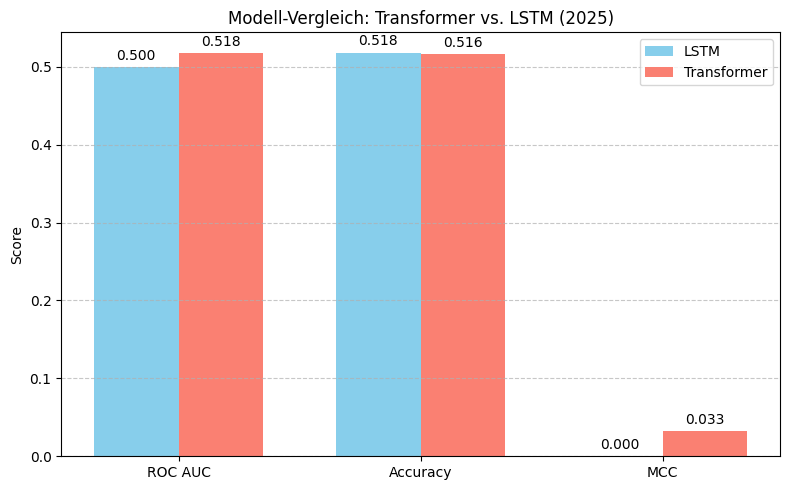

In [15]:
# === 4. VERGLEICH & VISUALISIERUNG ===

# DataFrame erstellen, um die Ergebnisse nebeneinander zu sehen
comparison = pd.DataFrame({
    "Metric": ["Accuracy", "Balanced Acc", "ROC AUC", "MCC"],
    "LSTM": [
        lstm_metrics["report"]["accuracy"],
        lstm_metrics["balanced_accuracy"],
        lstm_metrics["roc_auc"],
        lstm_metrics["mcc"]
    ],
    "Transformer": [
        trans_metrics["accuracy"],
        trans_metrics["balanced_accuracy"],
        trans_metrics["roc_auc"],
        trans_metrics["mcc"]
    ]
})

# Differenz berechnen (Positiv = Transformer ist besser)
comparison["Diff (Tr - LSTM)"] = comparison["Transformer"] - comparison["LSTM"]

# Tabelle anzeigen
print("Vergleichstabelle:")
display(comparison.round(4))

# Balkendiagramm zur Visualisierung
metrics = ["ROC AUC", "Accuracy", "MCC"]
x = np.arange(len(metrics))
width = 0.35

vals_lstm = [lstm_metrics["roc_auc"], lstm_metrics["report"]["accuracy"], lstm_metrics["mcc"]]
vals_trans = [trans_metrics["roc_auc"], trans_metrics["accuracy"], trans_metrics["mcc"]]

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, vals_lstm, width, label='LSTM', color='skyblue')
rects2 = ax.bar(x + width/2, vals_trans, width, label='Transformer', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Modell-Vergleich: Transformer vs. LSTM (2025)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Werte direkt an die Balken schreiben
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

plt.tight_layout()

# Plot speichern
plt.savefig(TRANS_RES_DIR / "model_comparison.png")
plt.show()